In [136]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import general_utils.LDI_VIF as LV
import numpy as np

utils.default_plot_format()
utils.pd_display_settings(3)

In [137]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"

In [138]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

#indicator_columns.remove('D2')
#non_linear_metrics.remove('D2')

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [139]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

metrics = ['HF Power', 'SDRR', 'SD2', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

metrics = time_metrics
#median_melted = median_melted[median_melted["metric"].isin(metrics)]


median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
print(median_pivot.columns)

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')


In [192]:
def run_pca(data):
    clusters = 2
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(median_pivot)
    

    dpn = median_pivot["DPN"].astype(int)
    pca = PCA(3)
    pca.fit(median_pivot)
    pca_data = pd.DataFrame(pca.transform(median_pivot))
    return clusters,kmeans, pca_data, dpn

clusters, kmeans, pca_data, dpn = run_pca(median_pivot)

In [ ]:
def plt_pca(pca_data, kmeans, dpn):


    fig = go.Figure()
    str_labels = [label for label in kmeans.labels_]
    cluster_colors = {0: 'blue', 1: 'red'}
    cluster_colors = dict(zip(range(2), cluster_colors.values()))

    fig.add_trace(go.Scatter3d(
        x=pca_data[0],
        y=pca_data[1],
        z=pca_data[2],
        mode='markers+text',
        marker=dict(
            size=5,
            color=list(map(lambda label: cluster_colors[label], dpn)),
            opacity=0.8
        ),
        text=str_labels,
        textposition='top center'
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3',
            aspectratio=dict(x=1, y=1, z=1),
            aspectmode='cube'
        ),
        width=600, height=500,
        margin=dict(l=10, r=10, b=10, t=10)
    )

    fig.show()


# LDA

In [143]:
median = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()

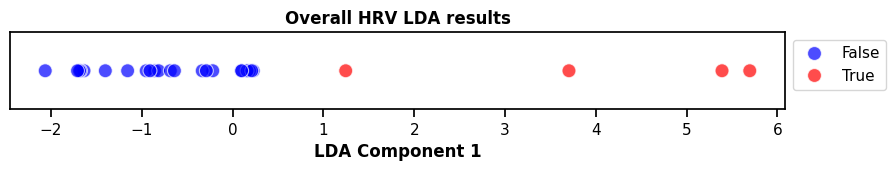

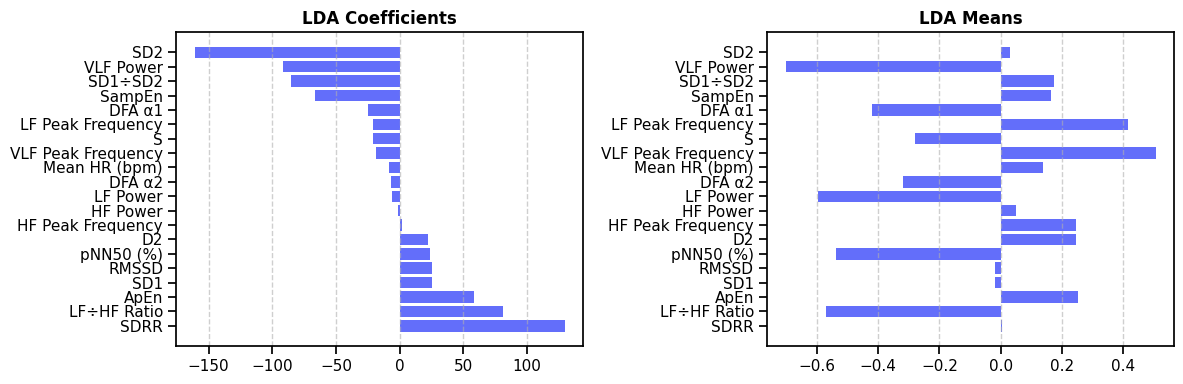

In [144]:
lda_df, lda = LV.perform_lda(median, indicator_columns)
LV.plot_linear_lda(lda_df, "Overall HRV LDA results", cluster_colors)
df = LV.show_linear_lda_stats(lda, indicator_columns)

In [145]:
from IPython.display import display
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)


Columns,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),VLF Power,VLF Peak Frequency,LF Power,LF Peak Frequency,HF Power,HF Peak Frequency,LF÷HF Ratio,S,SD1,SD2,SD1÷SD2,ApEn,SampEn,DFA α1,DFA α2,D2
LDA Coef,129.48,25.19,24.01,-8.19,-91.57,-18.46,-5.77,-21.10,-1.18,1.69,81.26,-20.82,25.27,-160.86,-85.57,58.55,-66.36,-24.67,-6.96,22.09
Means,0.00318,-0.0194,-0.54,0.14,-0.70,0.50,-0.60,0.42,0.0501,0.24,-0.57,-0.28,-0.0194,0.0286,0.17,0.25,0.16,-0.42,-0.32,0.25


LDA allows to isolate all of the DPN patients by over-fitting.

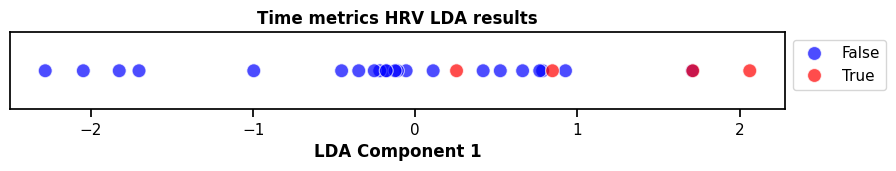

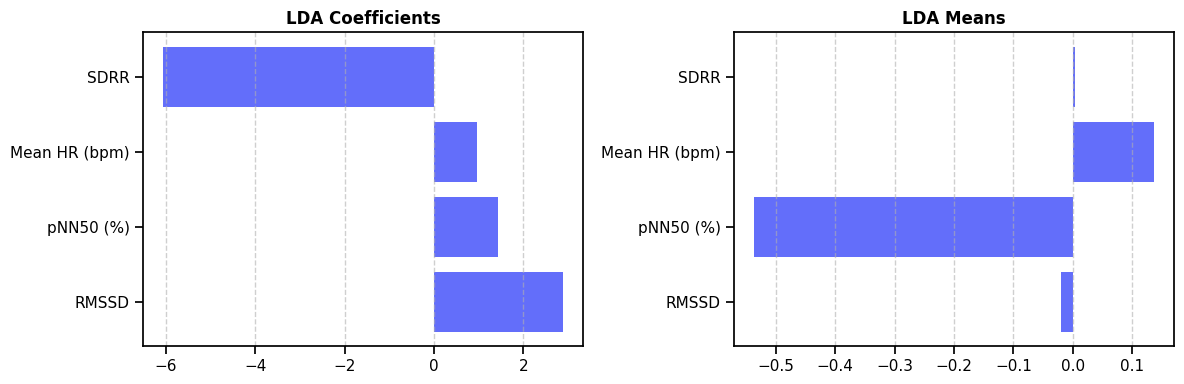

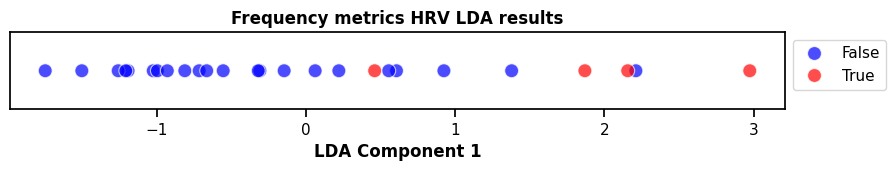

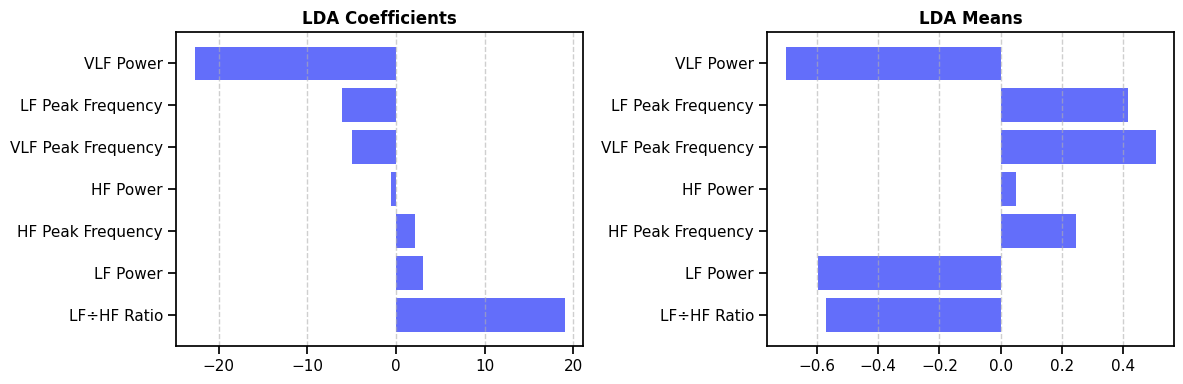

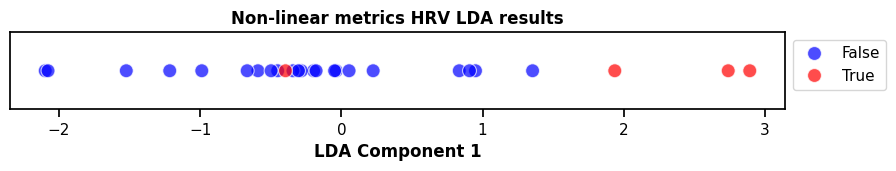

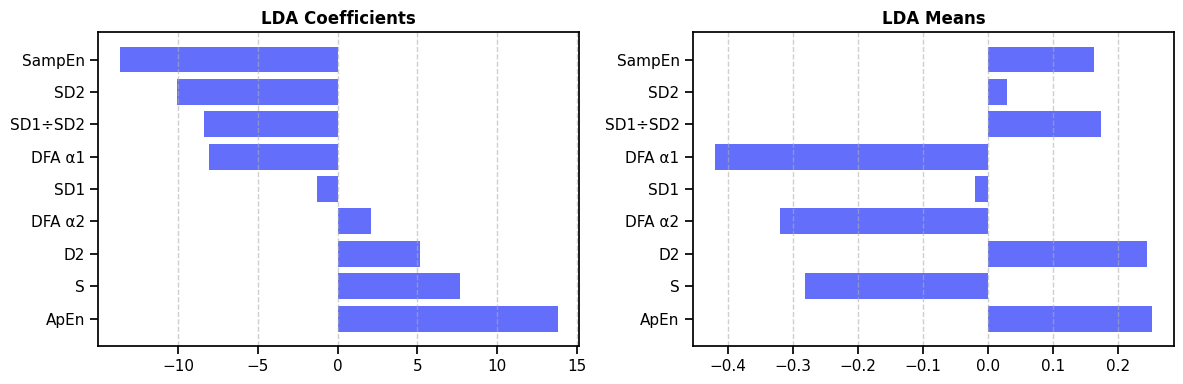

In [146]:
metric_lda = [] 
for col, name in zip([time_metrics, frequency_metrics, non_linear_metrics], ["Time", "Frequency", "Non-linear"]):
    lda_df, lda = LV.perform_lda(median_pivot, col)
    LV.plot_linear_lda(lda_df,  f"{name} metrics HRV LDA results")
    LV.show_linear_lda_stats(lda, col)
    metric_lda.append([lda, lda_df, name])


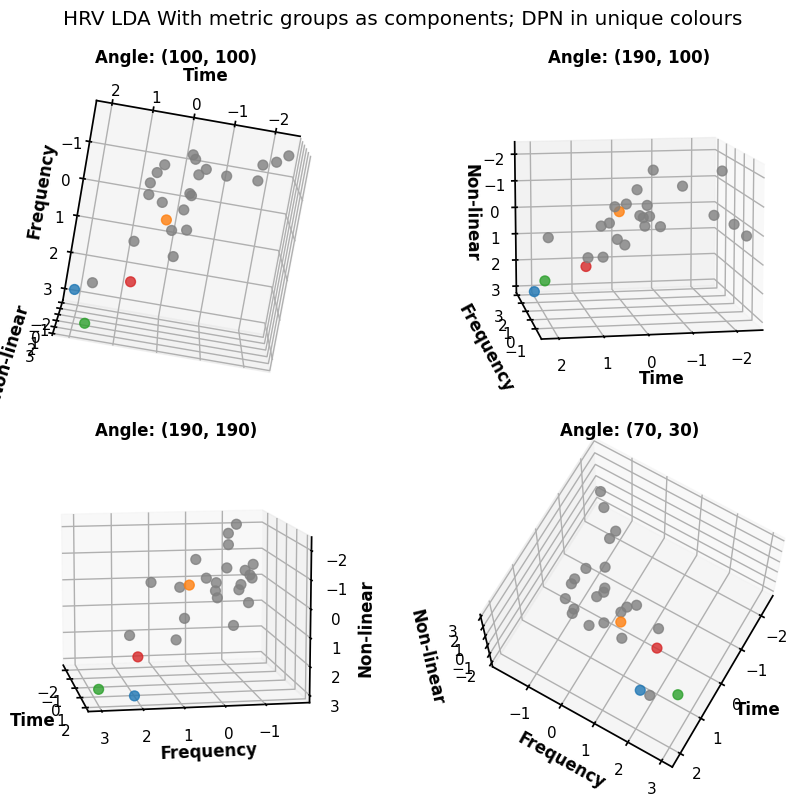

In [147]:
full_df = pd.DataFrame()
for lda, lda_df, name in metric_lda:
    full_df[name] = lda_df[0]
    
full_df["cluster"] = metric_lda[0][1]["Cluster"]


unique_dpn = full_df[full_df['cluster']].index
dpn_colors = {idx: color for idx, color in zip(unique_dpn, mcolors.TABLEAU_COLORS)}

fig = plt.figure(figsize=(10, 8))

# Define the angles for the subplots
angles = [(100, 100), (190, 100), (190, 190), (70, 30)]

fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, angle in enumerate(angles):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    ax.scatter(full_df['Time'], full_df['Frequency'], full_df['Non-linear'], 
               c=[dpn_colors[idx] if idx in dpn_colors else 'gray' for idx in full_df.index], 
               s=50, alpha=0.8)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Non-linear')
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'Angle: {angle}')

plt.suptitle('HRV LDA With metric groups as components; DPN in unique colours')
plt.tight_layout()
plt.show()

### LDA Man whitney >0.10

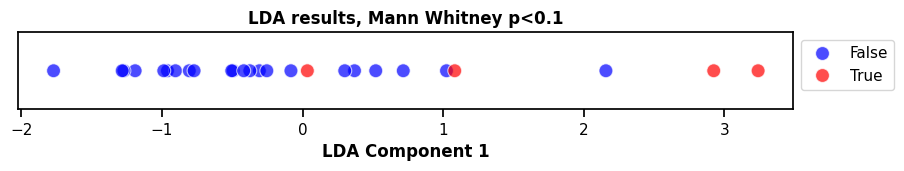

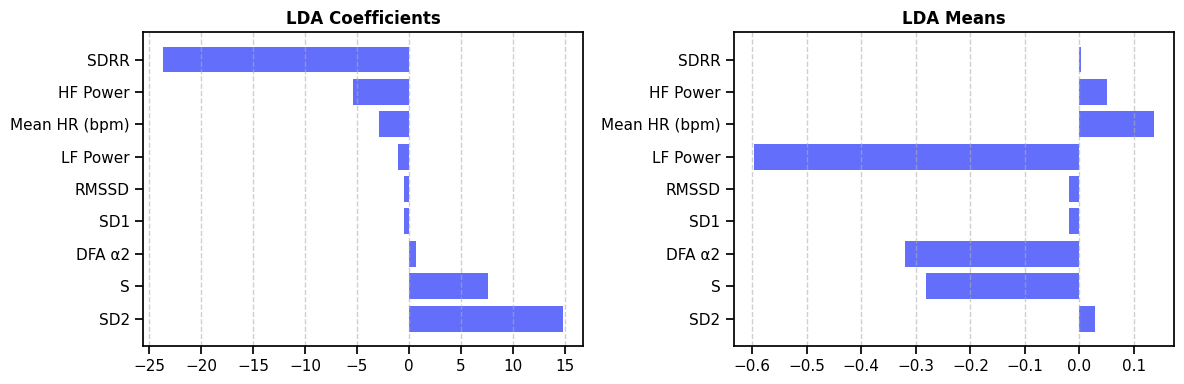

In [148]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = LV.perform_lda(median_pivot, col)
LV.plot_linear_lda(lda_df,  "LDA results, Mann Whitney p<0.1")
df = LV.show_linear_lda_stats(lda, col)

# LDA permutations <0.1

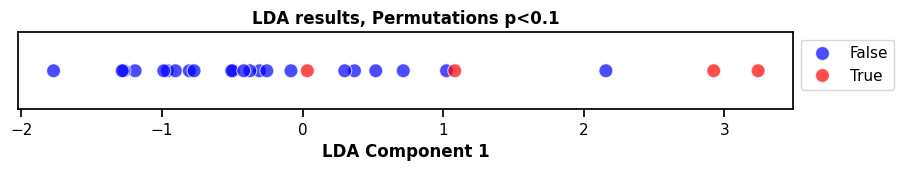

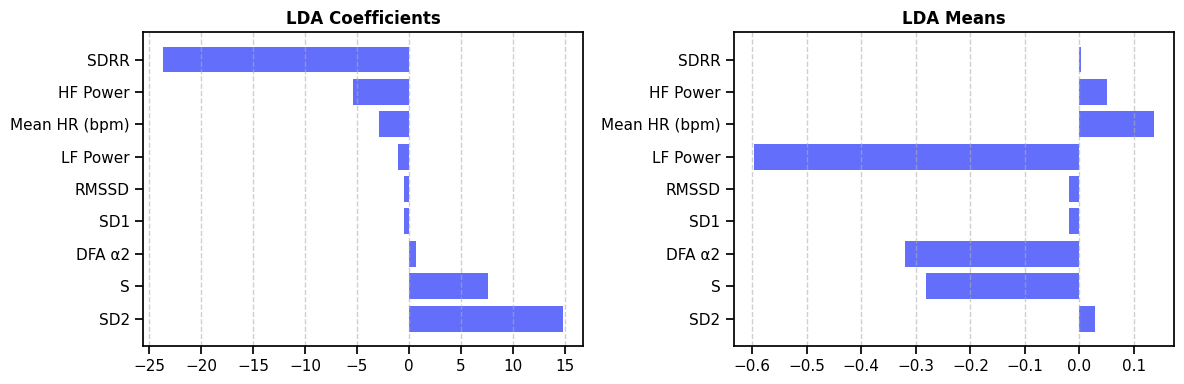

In [149]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = LV.perform_lda(median_pivot, col)
LV.plot_linear_lda(lda_df,  "LDA results, Permutations p<0.1")
df = LV.show_linear_lda_stats(lda, col)

In [150]:
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)

Columns,HF Power,SD2,SDRR,Mean HR (bpm),LF Power,DFA α2,S,RMSSD,SD1
LDA Coef,-5.40,14.80,-23.68,-2.91,-1.06,0.62,7.57,-0.45,-0.45
Means,0.0501,0.0286,0.00318,0.14,-0.60,-0.32,-0.28,-0.0194,-0.0194


# Classifier and LDA

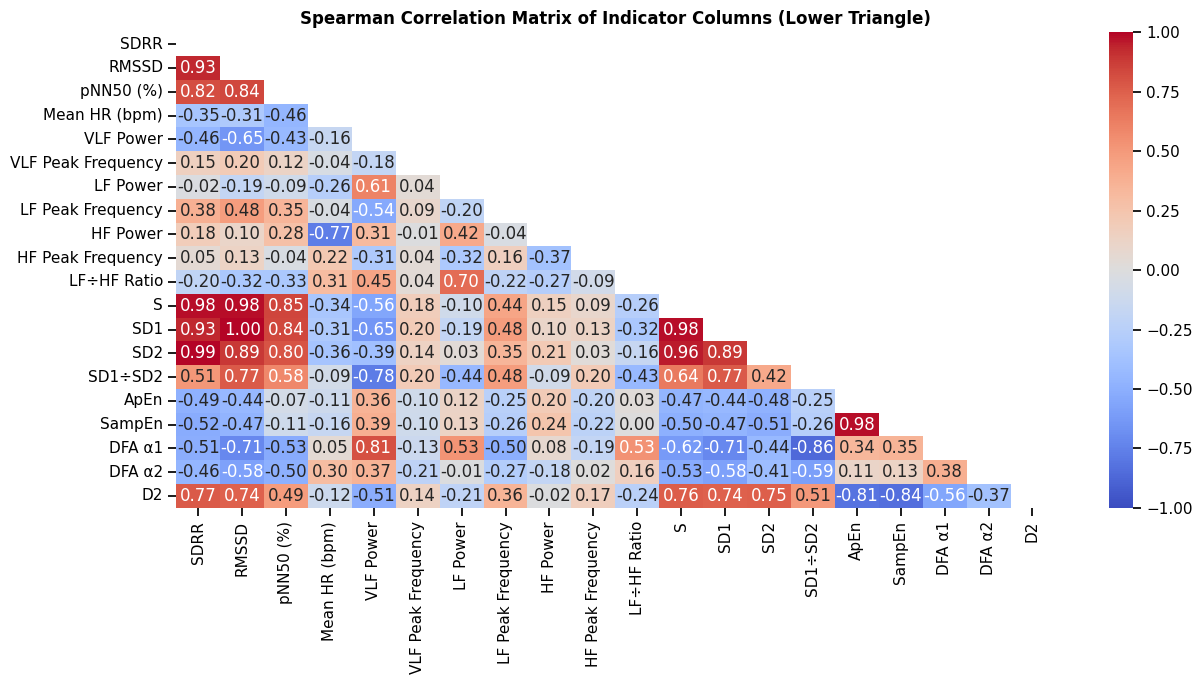

In [151]:
# Calculate the correlation matrix
import numpy as np
correlation_matrix = data[indicator_columns].corr(method='spearman')

# Plot the heatmap
# Get the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(13, 7))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', center=0, vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix of Indicator Columns (Lower Triangle)')
plt.tight_layout()
plt.show()

In [152]:
def plot_vif(data:pd.DataFrame, height=5):
    nan_columns = data[data.isna().any(axis=1)]["feature"].tolist()
    melted_data = data.melt(id_vars=["feature"], value_vars=["Full VIF", "Excluded VIF"], var_name="VIF Type", value_name="VIF Value")
    plt.figure(figsize=(8, height))
   
    sns.barplot(x="VIF Value", y="feature", hue="VIF Type", data=melted_data, dodge=True)
    plt.title(f"VIF for wine variables; Excluded VIF for {nan_columns}")
    plt.legend()
    plt.xscale('log')
    plt.grid(axis='x', linestyle='-', alpha=0.5)
    plt.grid(axis='x', linestyle='--', which='minor',alpha = 0.5)
    plt.tight_layout()
    plt.show()

In [153]:
median.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  26 non-null     int64  
 1   DPN                 26 non-null     bool   
 2   ApEn                26 non-null     float64
 3   D2                  26 non-null     float64
 4   DFA α1              26 non-null     float64
 5   DFA α2              26 non-null     float64
 6   HF Peak Frequency   26 non-null     float64
 7   HF Power            26 non-null     float64
 8   LF Peak Frequency   26 non-null     float64
 9   LF Power            26 non-null     float64
 10  LF÷HF Ratio         26 non-null     float64
 11  Mean HR (bpm)       26 non-null     float64
 12  RMSSD               26 non-null     float64
 13  S                   26 non-null     float64
 14  SD1                 26 non-null     float64
 15  SD1÷SD2             26 non-null     float64
 16  SD2       

In [154]:
import general_utils.LDI_VIF as LV
importlib.reload(LV)

LV.get_vif(median.drop(columns =['id', 'DPN']), ['SDRR', 'VLF Power'])

,feature,Full VIF,Excluded VIF
12,SD1,6923762851,6822932830
10,RMSSD,6923560612,6822746774
0,ApEn,4443,3760
16,SampEn,2924,2445
2,DFA α1,1221,1159
9,Mean HR (bpm),1293,967.65
17,VLF Peak Frequency,1335,517.26
13,SD1÷SD2,623.01,454.14
6,LF Peak Frequency,1176,440.81
3,DFA α2,516.75,435.18


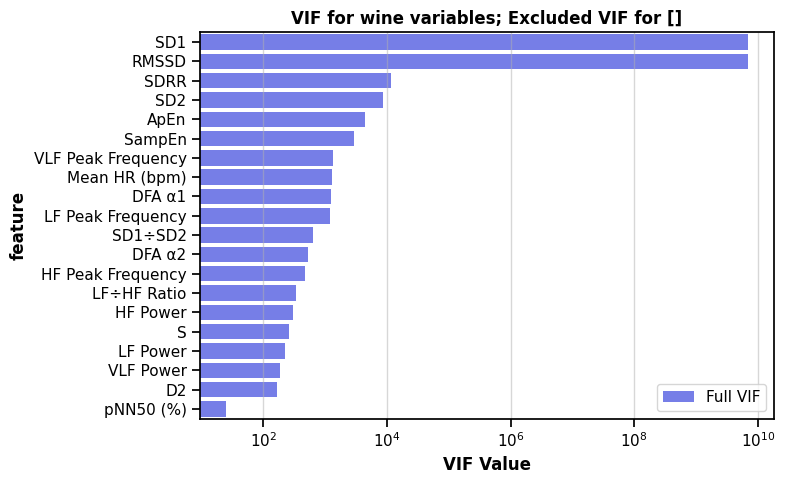

In [155]:


LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))

Log classifier fails to converge, because a separation could not be identified.

## LDA feature isolation

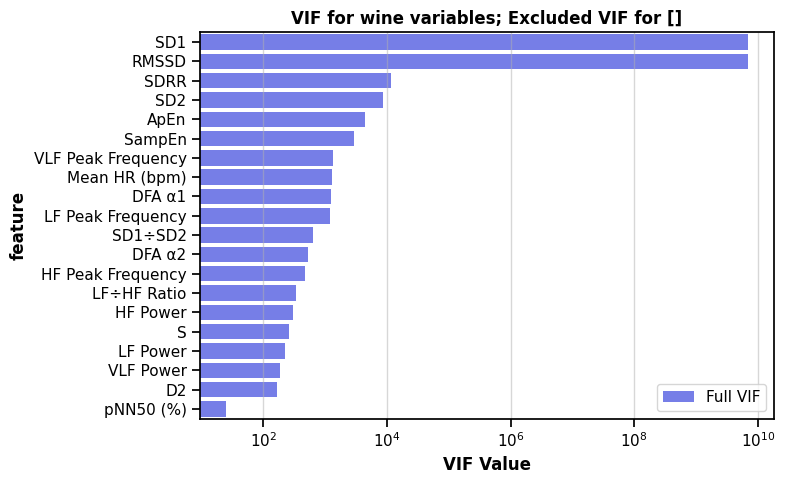

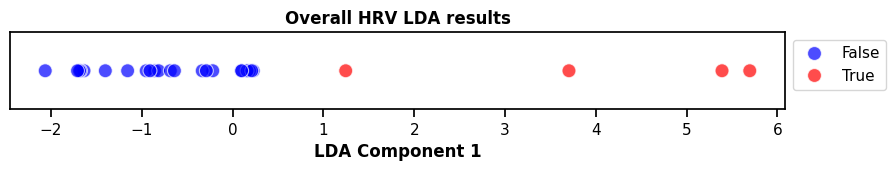

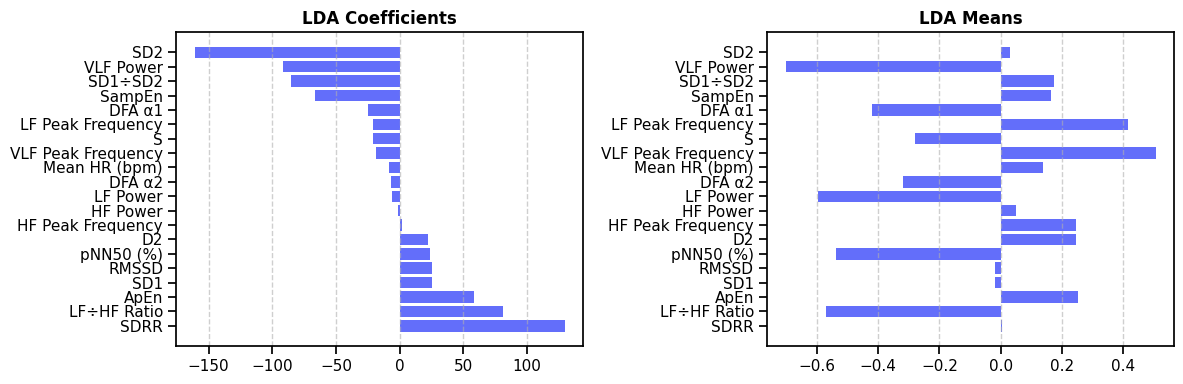

In [156]:
LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))
lda_df, lda = LV.perform_lda(median, indicator_columns)
LV.plot_linear_lda(lda_df, "Overall HRV LDA results")
df = LV.show_linear_lda_stats(lda, indicator_columns)


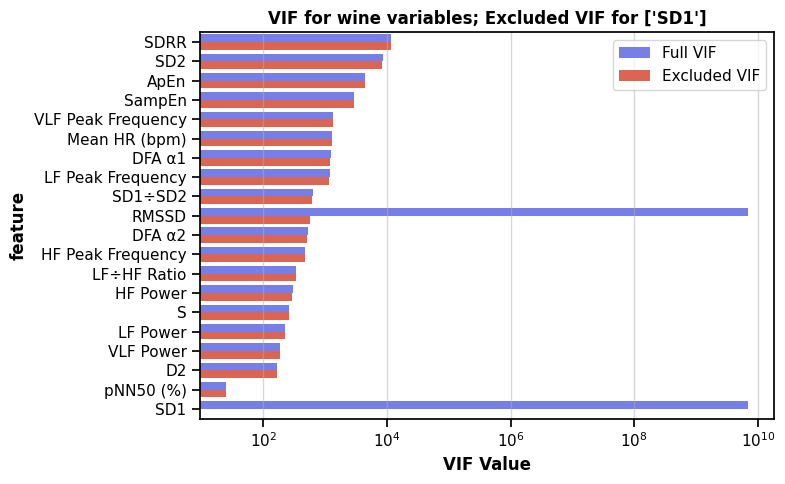

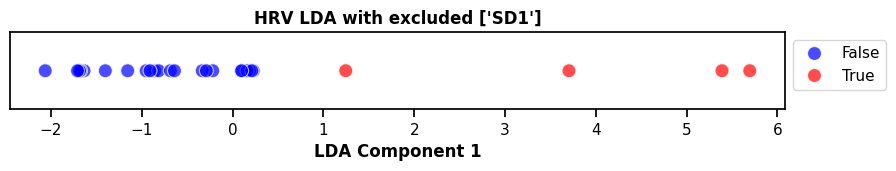

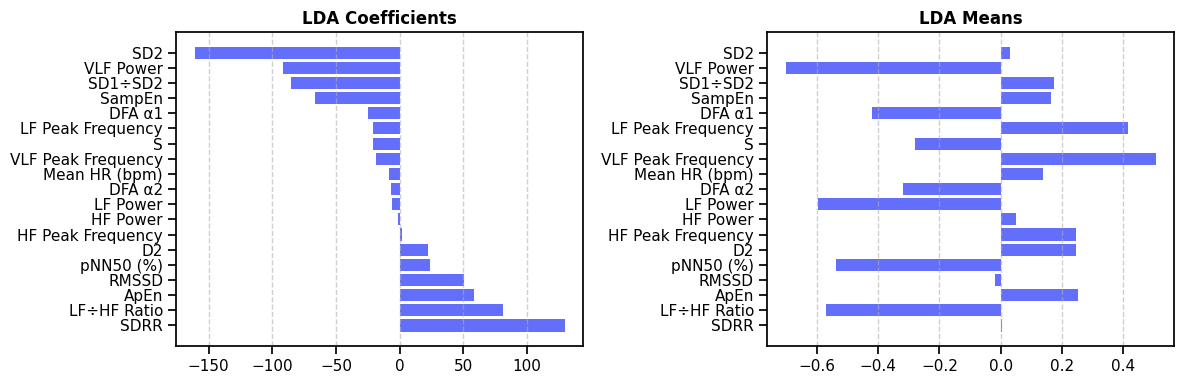

In [157]:
LV.lda_vif_exclude(median, 'SD1')
median = median.drop(columns ='SD1')

SD can be very easily excluded

In [158]:
median.columns

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1÷SD2', 'SD2', 'SDRR', 'SampEn',
       'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

index.columns

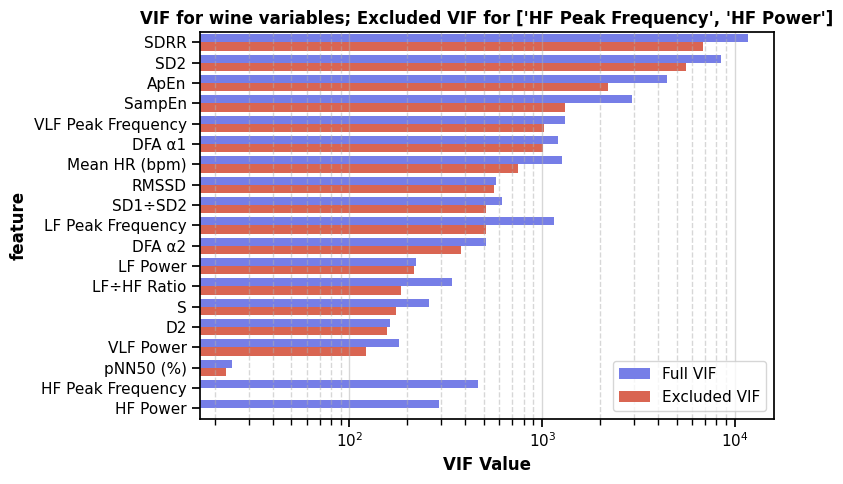

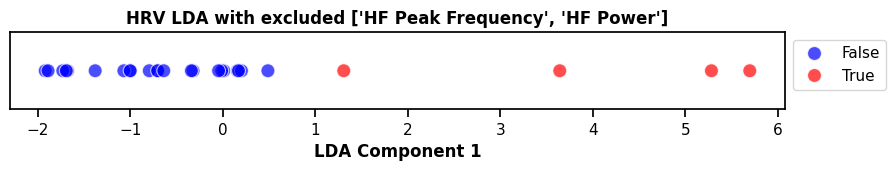

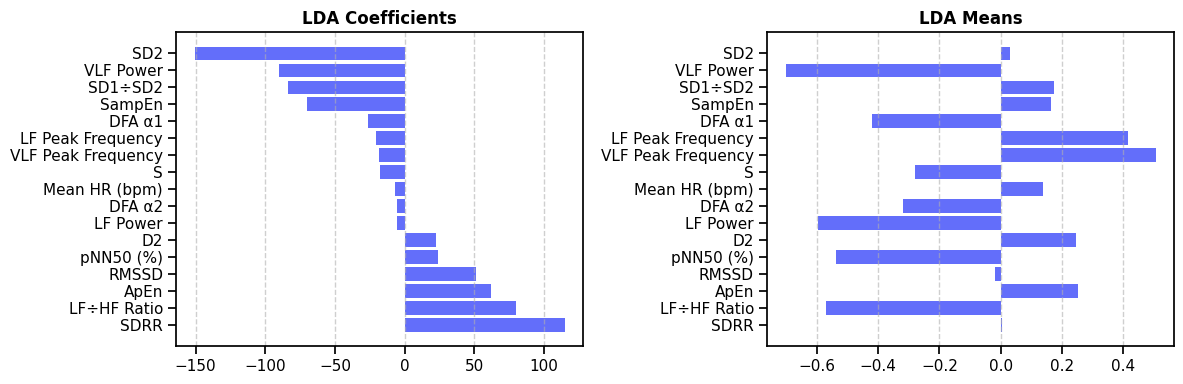

In [159]:
LV.lda_vif_exclude(median, ['HF Peak Frequency', 'HF Power'])
median = median.drop(columns =['HF Peak Frequency', 'HF Power'])


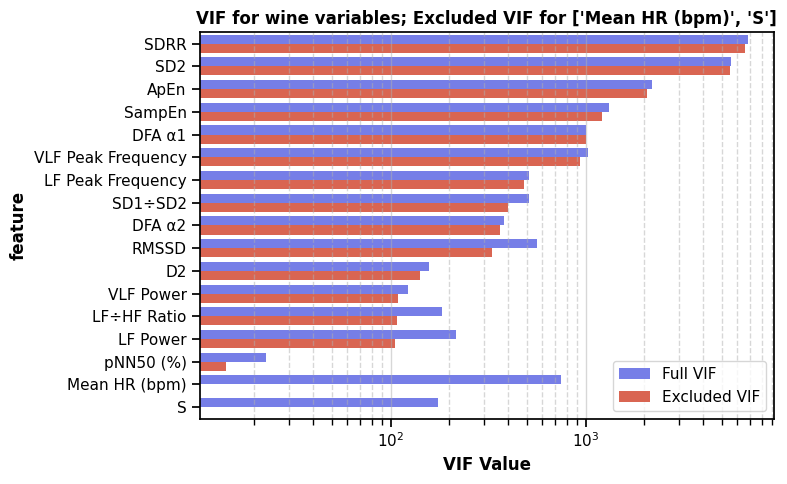

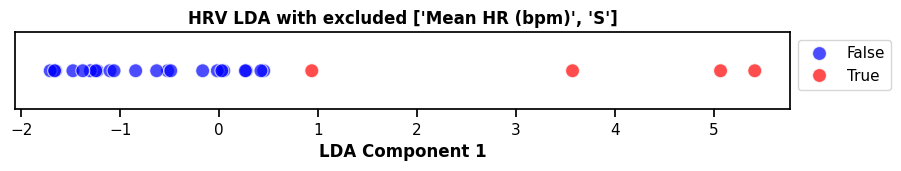

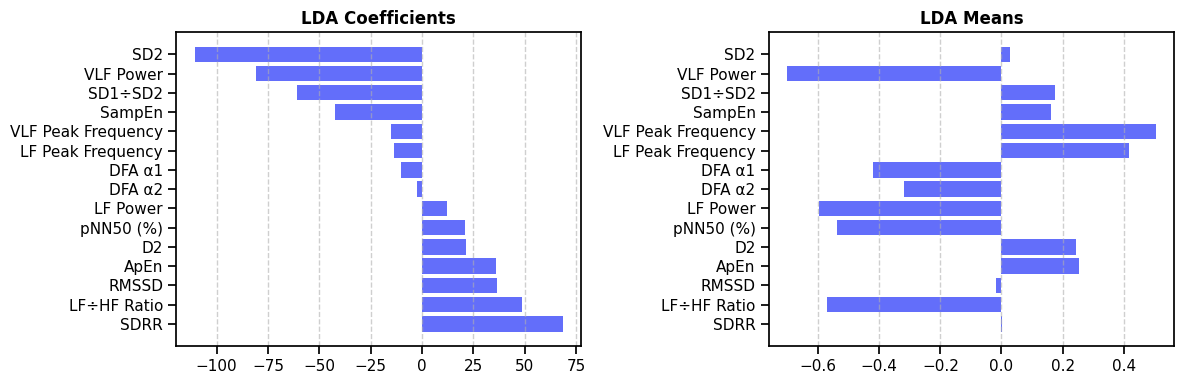

In [160]:
LV.lda_vif_exclude(median, ['Mean HR (bpm)', 'S'])
median = median.drop(columns =['Mean HR (bpm)', 'S'])

In [161]:
median.columns

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF Power', 'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'SampEn',
       'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

SD2 is too important for separation to drop

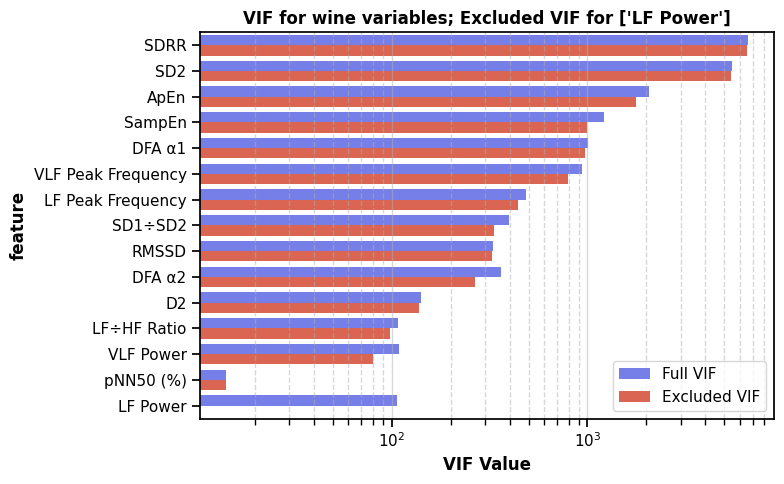

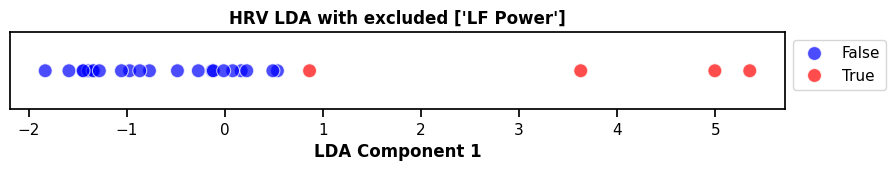

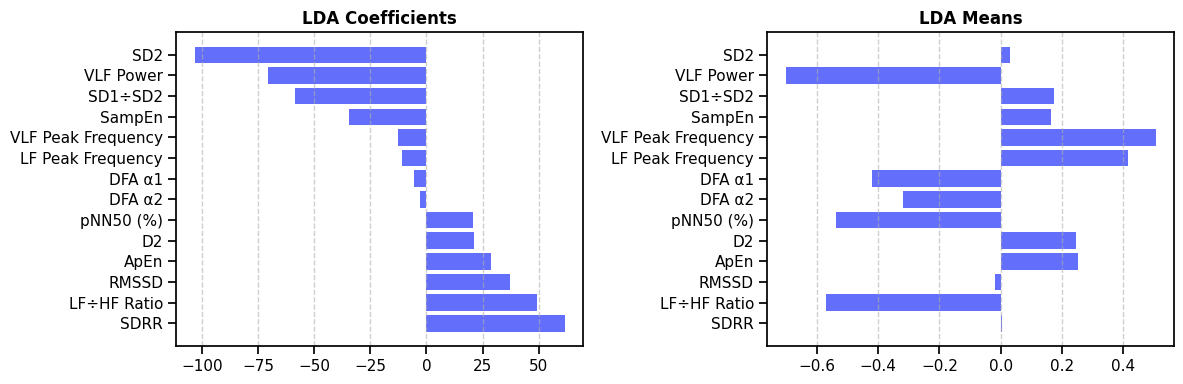

In [162]:
LV.lda_vif_exclude(median, ['LF Power', ])
median = median.drop(columns =['LF Power'])


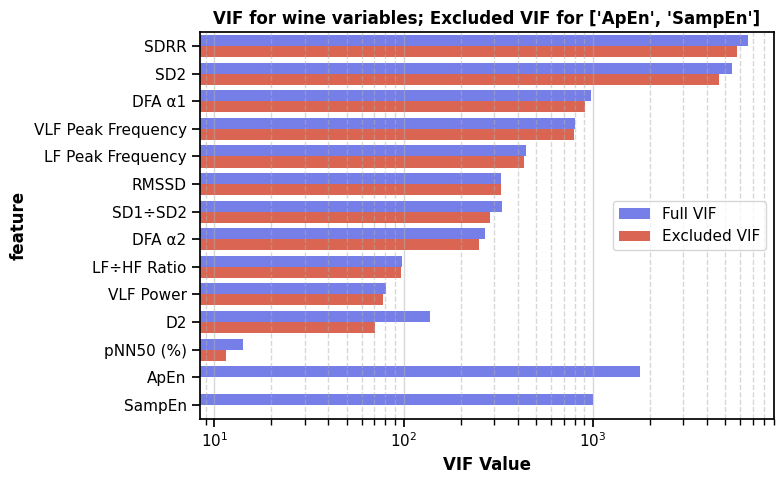

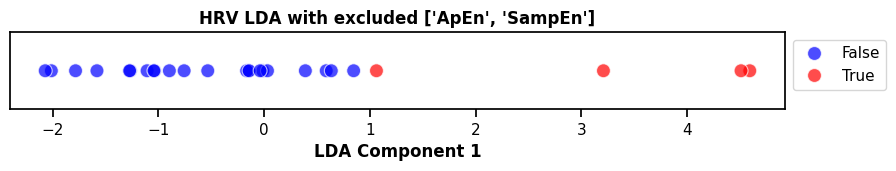

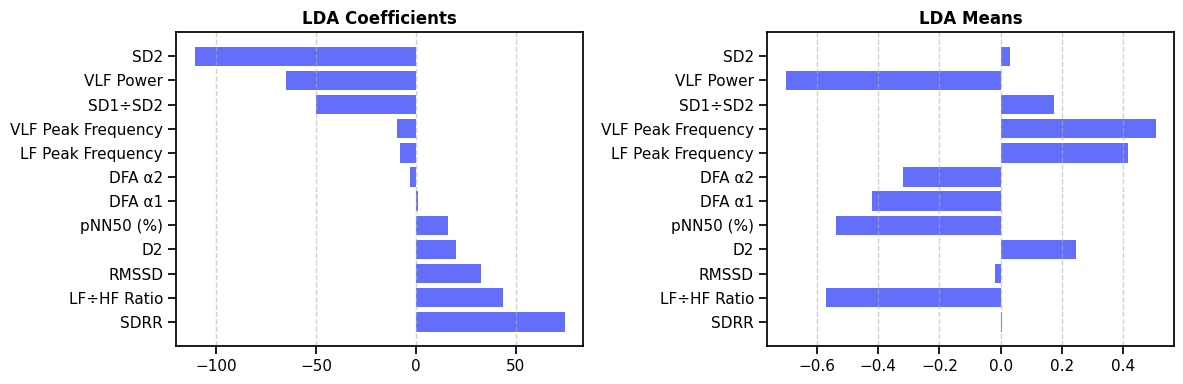

In [163]:
LV.lda_vif_exclude(median, ['ApEn', 'SampEn'])
median = median.drop(columns =['ApEn', 'SampEn'])

In [164]:
median.columns

Index(['id', 'DPN', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'VLF Peak Frequency',
       'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

Apen has no result

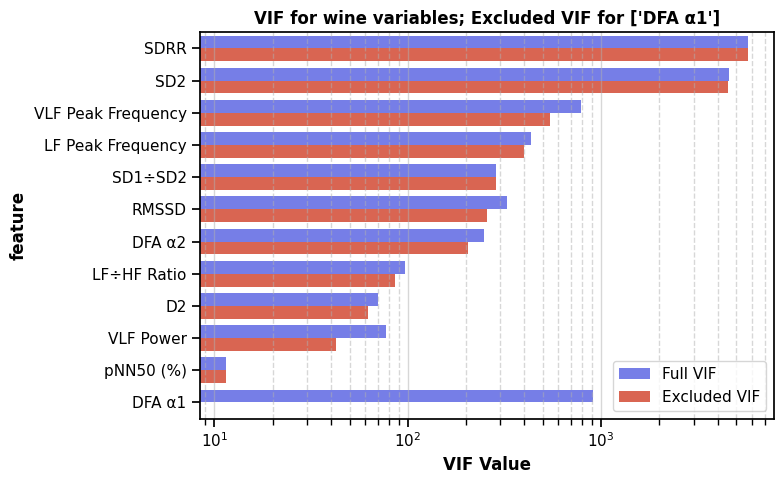

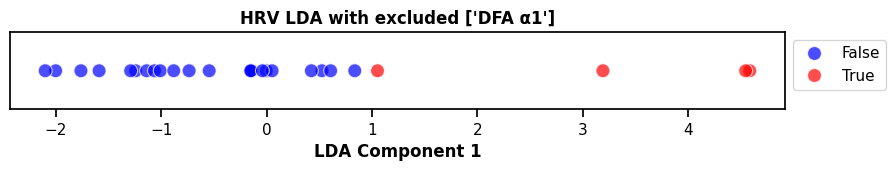

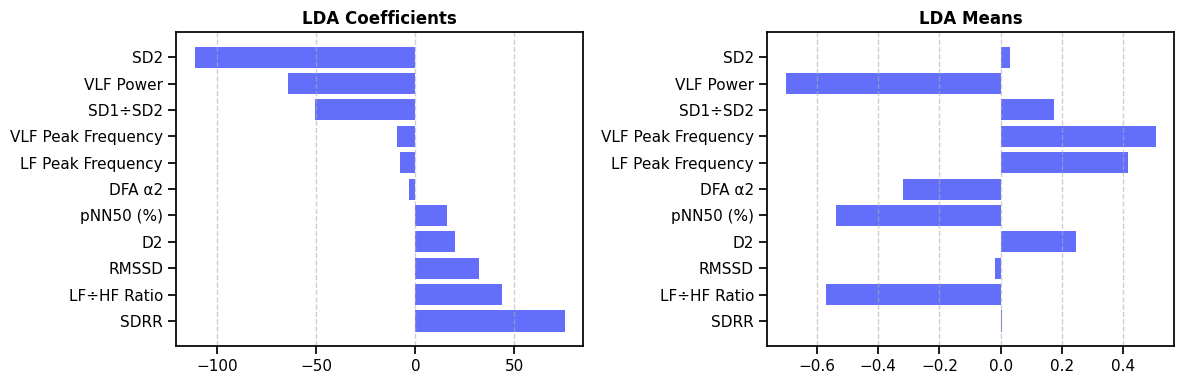

In [165]:
LV.lda_vif_exclude(median, ['DFA α1'])
data.drop(columns =['DFA α1']);


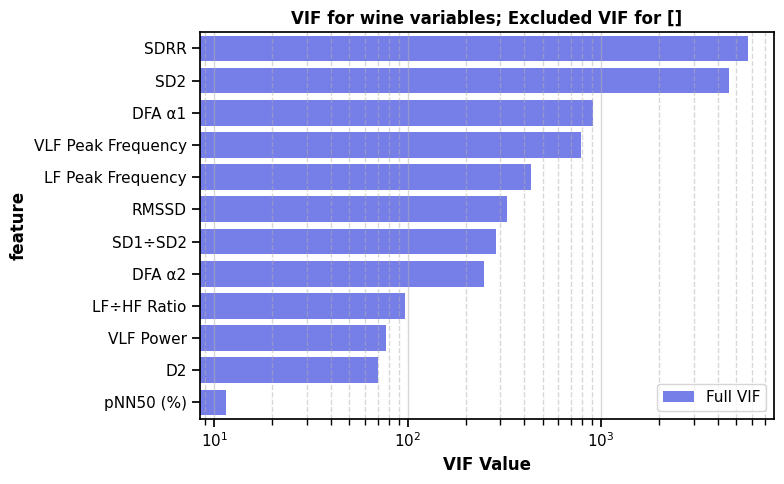

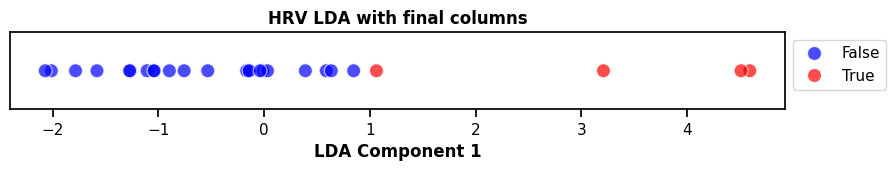

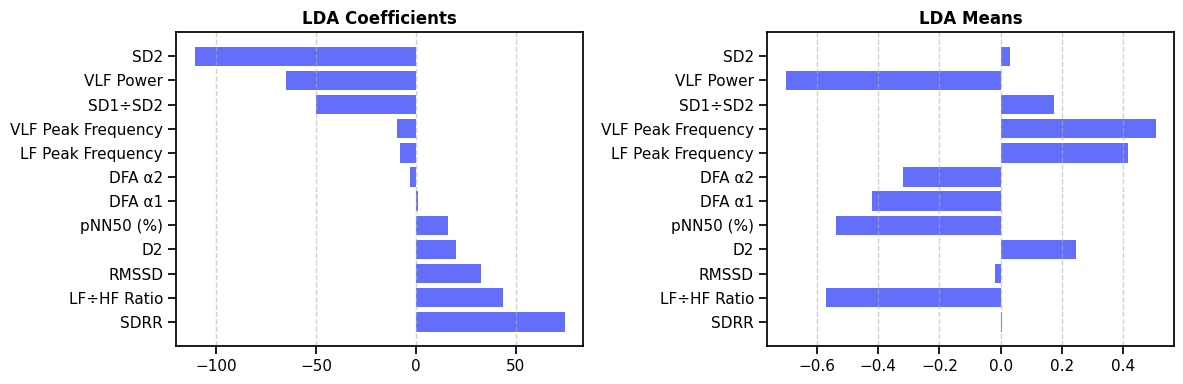

In [ ]:
LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))
lda_df, lda = LV.perform_lda(median, median.columns[2:])
LV.plot_linear_lda(lda_df, f"HRV LDA with final columns")
LV.show_linear_lda_stats(lda, median.columns[2:])

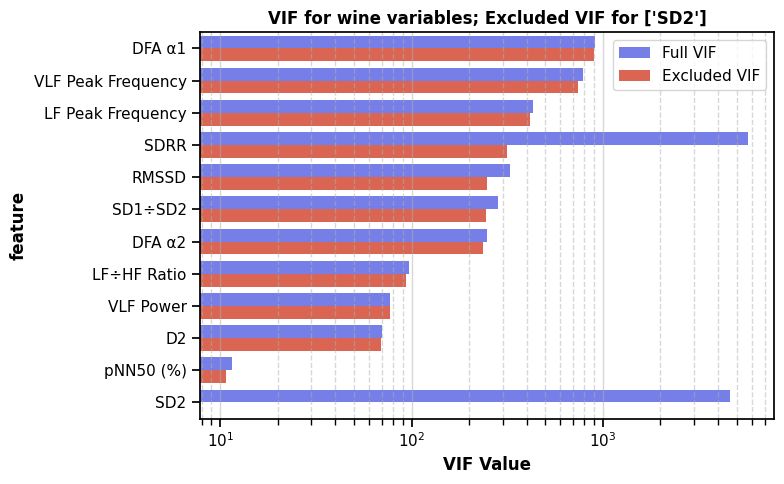

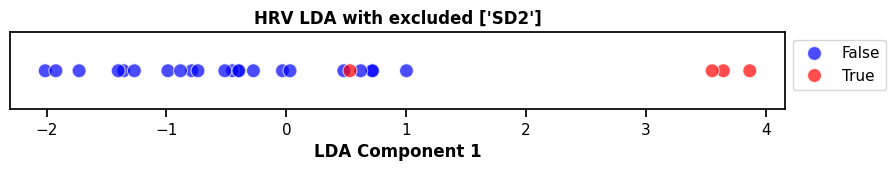

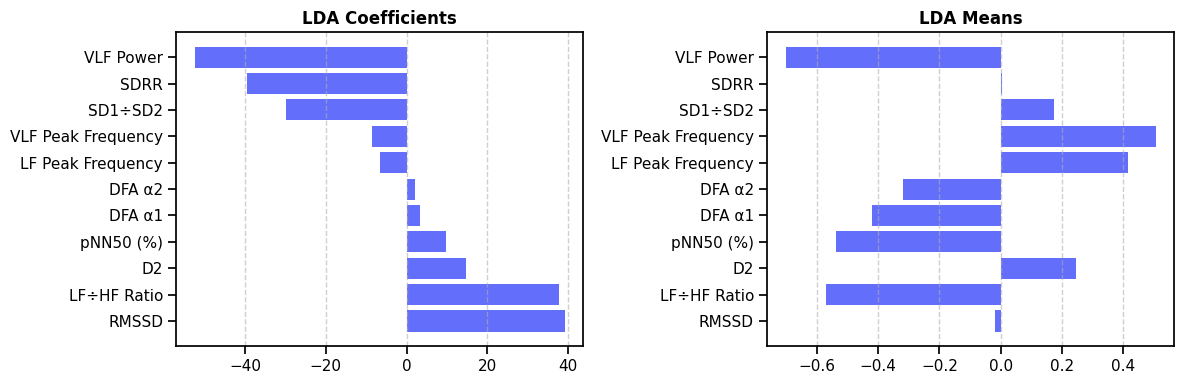

In [171]:
LV.lda_vif_exclude(median, ['SD2'])

## VIF removal analysis

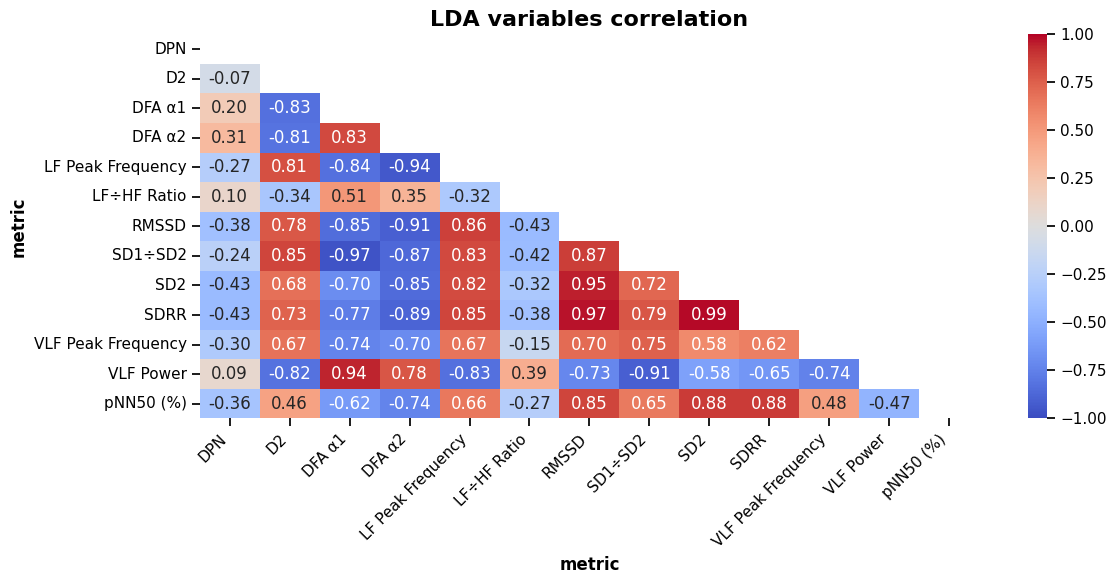

In [169]:
# Calculate the Spearman correlation matrix
correlation_matrix = median.drop(columns=['id']).corr(method='spearman')

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            annot=True, fmt='.2f')

plt.title('LDA variables correlation', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm


from sklearn.preprocessing import StandardScaler


def scale_data(data, equation_dict=median.drop(columns=['DPN']), extra_columns=[]):
    columns = list(equation_dict.keys())[1:]
    data = data.copy()[columns + ["DPN", *extra_columns]]
    scaler = StandardScaler()
    data[columns] = scaler.fit_transform(data[columns])
    data["DPN"] = data["DPN"].apply(lambda x: 0 if x <= 5 else 1)
    return data

scaled_train = scale_data(median.copy())

X_scaled = sm.add_constant(scaled_train.drop(columns=["DPN"]))

logit_model = sm.Logit(scaled_train["DPN"], X_scaled).fit()

         Current function value: 0.000000
         Iterations: 35


c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: Per